In [1]:
# Importing all libraries needed
import pandas as pd
import numpy as np
import eli5
from eli5.sklearn import PermutationImportance
from xgboost import XGBRegressor
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [2]:
# Import the housing data
X = pd.read_csv('melb_data.csv')
y = X.Price

# Drop the target column (Price)
X.drop(['Price'], inplace=True, axis=1)


# Check the size of the dataframe
X.shape

# Check for null values
y.isnull().sum()

np.int64(0)

In [3]:
# Split my data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1)

# Initialize my model
model = XGBRegressor(n_estimators=100, learning_rate=0.1)


In [4]:
# PREPROCESSING
# Check the datatype for all the columns
X.dtypes

# Seperate the numerical and object columns
num_cols = [col for col in X_train.columns if X_train[col].dtype in ['int64', 'float64']]

obj_cols = [col for col in X_train.columns if X_train[col].dtype in ['object'] 
            and X_train[col].nunique() < 10] # Make sure to check for high cardinality columns as well
# print(f'Numerical Columns: {num_cols}, \nCategorical Columns: {obj_cols}')

In [5]:
# PREPROCESSING
# Using column transformer, we impute our columns
preprocessor = ColumnTransformer(transformers=[('num', SimpleImputer(strategy='mean'), num_cols),
                                               ('obj', OneHotEncoder(handle_unknown='ignore'), obj_cols)])

##### This is the manual way to preprocess your data. The automatic way is using a pipeline. (Edit to view)
<!-- # Fit and transform the data. This way we can avoid data leakage
X_train_transformed = preprocessor.fit_transform(X_train)
X_valid_transformed = preprocessor.transform(X_valid)

# This is to check our transformed data to see if there are any null values
# It is not necessary at all
print(X_train_transformed.shape) 

X_train_transformed_df = pd.DataFrame(
    X_train_transformed,
    columns=preprocessor.get_feature_names_out())

# Check for missing values
print(X_train_transformed_df.isnull().sum()) -->

In [6]:
# We create a pipeline for our model
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])

# Fit the model (Training the model)
my_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  ['Rooms', 'Distance',
                                                   'Postcode', 'Bedroom2',
                                                   'Bathroom', 'Car',
                                                   'Landsize', 'BuildingArea',
                                                   'YearBuilt', 'Lattitude',
                                                   'Longtitude',
                                                   'Propertycount']),
                                                 ('obj',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Type', 'Method',
                                                   'Regionname'])])),
                ('model',
                 XGBRegressor(base_score=None, boos...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [83]:
# PERMUTATION IMPORTANCE - To check for important features
# Transform the validation data first
X_valid_transformed = my_pipeline.named_steps['preprocessor'].transform(X_valid)

# Get the transformed feature names
feature_names = preprocessor.get_feature_names_out()

# Remove prefix like "num__" or "obj__"
cleaned_feature_names = [name.split("__")[-1] for name in feature_names]

# Fit the permutation importance on validation data
perm = PermutationImportance(my_pipeline.named_steps['model'], random_state=1)
perm.fit(X_valid_transformed, y_valid)

# Show weights with ELI5
# eli5.show_weights(perm, feature_names=cleaned_feature_names)

X_valid_transformed[:, 0]

array([4., 2., 5., ..., 4., 4., 3.])

In [82]:
cleaned_feature_names

['Rooms',
 'Distance',
 'Postcode',
 'Bedroom2',
 'Bathroom',
 'Car',
 'Landsize',
 'BuildingArea',
 'YearBuilt',
 'Lattitude',
 'Longtitude',
 'Propertycount',
 'Type_h',
 'Type_t',
 'Type_u',
 'Method_PI',
 'Method_S',
 'Method_SA',
 'Method_SP',
 'Method_VB',
 'Regionname_Eastern Metropolitan',
 'Regionname_Eastern Victoria',
 'Regionname_Northern Metropolitan',
 'Regionname_Northern Victoria',
 'Regionname_South-Eastern Metropolitan',
 'Regionname_Southern Metropolitan',
 'Regionname_Western Metropolitan',
 'Regionname_Western Victoria']

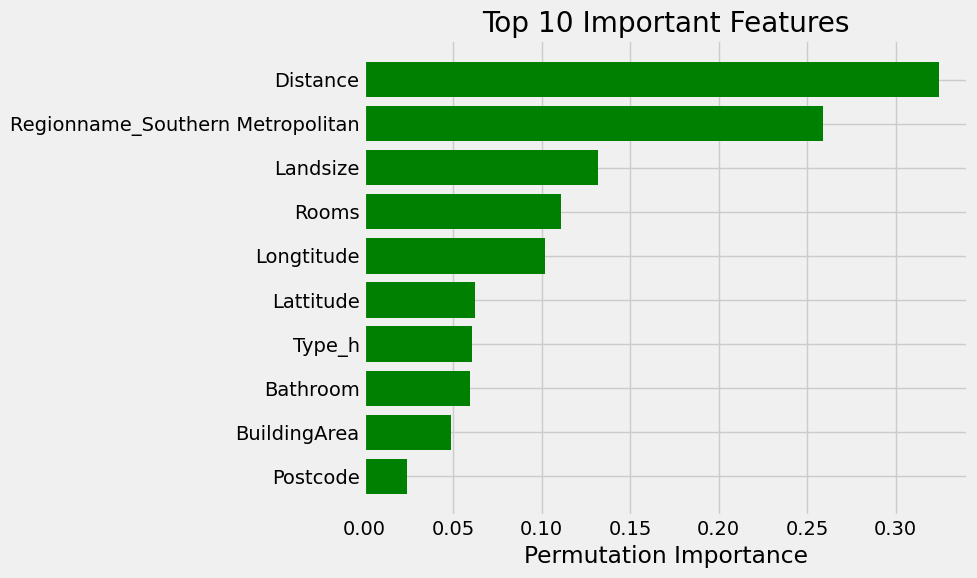

In [74]:
# PERMUTATION IMPORTANCE
# Save permutation importance to a DataFrame:
important_df = eli5.explain_weights_df(perm)

# Map ELI5's generic feature names (like 'x0', 'x1', etc.) to actual feature names
# Step 1: Extract the index number from the feature string (e.g., 'x7' → 7)
important_df["feature"] = important_df["feature"].str.extract(r"(\d+)").astype(int)

# Step 2: Use the extracted index to look up the corresponding name from the transformed feature list
important_df["feature"] = important_df["feature"].apply(lambda i: cleaned_feature_names[i])

# Print or log top 10
# important_df.head(10)

# Sort by absolute weight and take top 10
top_df = important_df.sort_values("weight", key=abs, ascending=False).head(10)

# Feature Importance Visualization
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 6))
plt.barh(top_df['feature'], top_df['weight'], color='green')
plt.xlabel("Permutation Importance")
plt.title('Top 10 Important Features')
plt.gca().invert_yaxis() # Invert the y-axis so that the most important features appear at the top of the plot
plt.tight_layout()
plt.show()

### SHAP Values (an acronym from SHapley Additive exPlanations) 

In [64]:
# Import the SHAP package — used for explaining predictions made by tree-based models
import shap  

# Use SHAP values to show the effect of each feature

# STEP 1: Select data for explanation
# Pick a specific row from the validation dataset to explain (row index 2 in this case)
row_to_show = 3
data_for_prediction = X_valid.iloc[[row_to_show]]  # Keep it as DataFrame to preserve column names

# Make a prediction on that row using the full pipeline (preprocessing + model)
prediction = my_pipeline.predict(data_for_prediction)

# STEP 2: Prepare data for SHAP
# Extract only the preprocessing step from the pipeline and apply it to the selected row
# This gives you the numerical feature vector that the model sees
data_transformed = my_pipeline.named_steps['preprocessor'].transform(data_for_prediction)

# Wrap the transformed row in a DataFrame, assigning cleaned feature names as column labels
# This ensures SHAP can display readable feature names instead of "Feature 0", "Feature 1", etc.
data_transformed_df = pd.DataFrame(data_transformed, columns=cleaned_feature_names)


# STEP 3: Explain prediction using SHAP
# Extract the trained model from the pipeline
model_only = my_pipeline.named_steps["model"]

# Create a SHAP explainer for the tree-based model (e.g., XGBoost)
explainer = shap.TreeExplainer(model_only)

# Calculate SHAP values for the selected (transformed) input row
shap_values = explainer.shap_values(data_transformed)

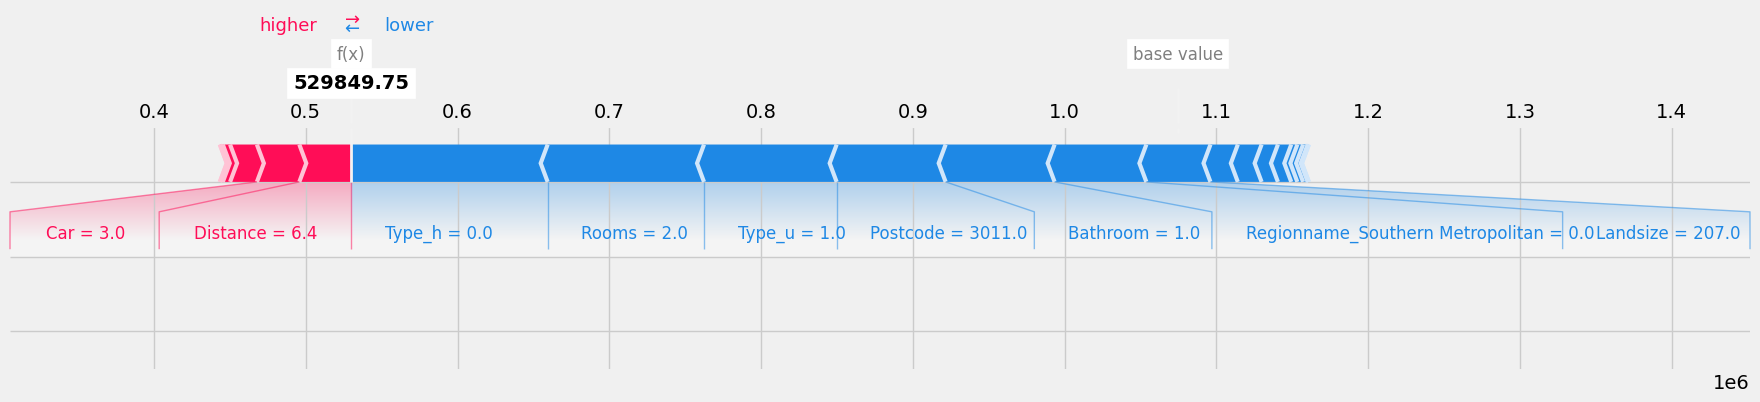

In [65]:
# STEP 4: Visualize SHAP Explanation
# Load JavaScript visualizations for interactive SHAP plots (works in Jupyter)
shap.initjs()

# Plot the SHAP explanation using a force plot, showing how each feature contributed to the prediction
# `expected_value`(baseline value): the average model output over training data
# `shap_values[0]`: the SHAP values for the selected row
# `data_transformed_df.iloc[0]`: the feature values for the row (with names)
shap.force_plot(
    explainer.expected_value, 
    shap_values, 
    data_transformed_df.iloc[0], 
    matplotlib=True  # optional for notebook-friendly display
    )

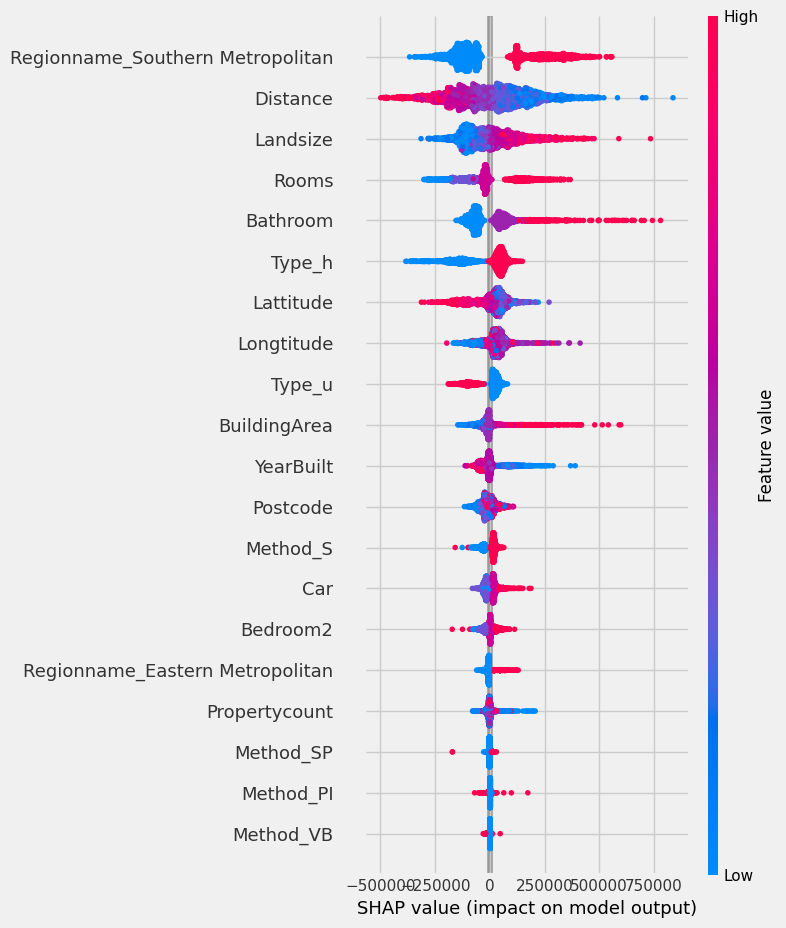

In [76]:
# SHAP SUMMARY PLOT
# Extract the trained model from the pipeline
model_only = my_pipeline.named_steps["model"]

# Create a SHAP explainer for the tree-based model (e.g., XGBoost)
explainer = shap.TreeExplainer(model_only)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of X_validation data rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_valid_transformed)

# Wrap the transformed X vallidation data in a DataFrame, assigning cleaned feature names as column labels
# This ensures SHAP can display readable feature names instead of "Feature 0", "Feature 1", etc.
X_valid_transformed_df = pd.DataFrame(X_valid_transformed, columns=cleaned_feature_names)

shap.summary_plot(shap_values, X_valid_transformed_df)

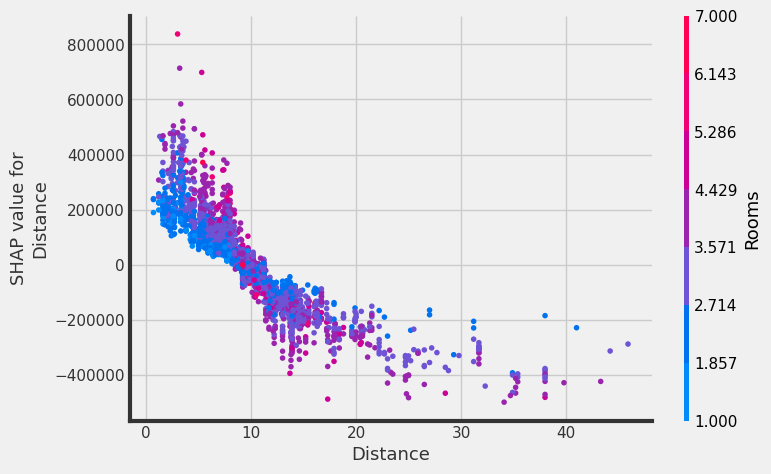

In [90]:
# Dependence Contribution Plots
""" 🔍 A SHAP dependence plot shows how changes in a feature’s value affect 
the model’s prediction, and how that effect might depend on another feature.
If you don't supply an argument for interaction_index, Shapley uses some logic to 
pick one that may be interesting  """

# make plot.
shap.dependence_plot('Distance', shap_values, X_valid_transformed_df, interaction_index='auto')

In [55]:
# Evaluate the model using validation data
preds = my_pipeline.predict(X_valid)

# Accuracy Metrics
print('Mean Absolute Error', mean_absolute_error(preds, y_valid))

Mean Absolute Error 154165.12371134022
